## RMM2

In [1]:
!pwd

/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/deep_CNN


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import hilbert_data1_jgrjd_20CRV3
import datetime
import matplotlib.pyplot as plt

In [3]:
def lowpass_scipy_butter(signal1,wn,lt):
    from scipy import signal
    w = 2/lt # Normalize the frequency
    b, a = signal.butter(wn, w, 'low')
    lowpass_signal = signal.filtfilt(b, a, signal1)

    return lowpass_signal


def data_y(st,en):

    df2       = pd.read_csv('full_data_nn_20CR_V3.txt',index_col='date')
    df2.index = pd.to_datetime(df2.index)
    df2=df2[(df2.index>=st) & (df2.index<=en)]    
    
    ################ RMM1 #########################
    y = df2.iloc[:,12:13]
    lf = 10;wn = 3
#    ### 10 days lowpass #############
    y1 = y.copy()
    for i in range(y.shape[1]):
        signal = y.iloc[:,i].values
        temp = lowpass_scipy_butter(signal,wn,lf)
        y1.iloc[:,i] = np.real(temp)
        
    RMM1 = y1.iloc[119:]
    del y,y1 

    ###################################    
    
     ################ RMM2 #########################
    y = df2.iloc[:,13:14]

#     ### 10 days lowpass #############
    y1 = y.copy()
    for i in range(y.shape[1]):
        signal = y.iloc[:,i].values
        temp = lowpass_scipy_butter(signal,wn,lf)
        y1.iloc[:,i] = np.real(temp)
    RMM2 = y1.iloc[119:]
    del y,y1 
#     ###################################    
       

    return RMM1,RMM2

In [4]:
df = xr.open_dataset('/home/cccr/roxy/panini/JGRJD_PHD_PART_I/JGRJD_DESKTOP/MJO_reconstruct_jgrjd/20CR_V3/CNN_maps_20CRV3/trop_sfc.ano_1905-2015_filtered_rm_mean120.4deg.nc')


In [5]:
y_train,_ = data_y(datetime.datetime(1979,1,1),datetime.datetime(2008,12,31))
y_test,_ = data_y(datetime.datetime(1974,6,1),datetime.datetime(1978,3,16))
y_test2,_ = data_y(datetime.datetime(2009,1,1),datetime.datetime(2015,12,31))

In [7]:
from sklearn.preprocessing import MinMaxScaler

sc3 = MinMaxScaler()

sc3.fit(y_train[:])

train_y = sc3.transform(y_train)
test_y  = sc3.transform(y_test)
test_y2  = sc3.transform(y_test2)

In [8]:
df_test3 = df.sel(lat=slice(-25,25))

In [9]:
from sklearn.preprocessing import MinMaxScaler
xtest3 = df_test3.pres_ano.values[:,:,:].copy()
scalers = {}
for i in range(xtest3.shape[0]):
    scalers = MinMaxScaler()
    num= df_test3.pres_ano.shape[1]*df_test3.pres_ano.shape[2]
    ff = xtest3[i,:,:].reshape(num,1)
    scalers.fit(ff)
    xtest3[i,:,:] = np.reshape(scalers.fit_transform(ff),(df_test3.pres_ano.shape[1],df_test3.pres_ano.shape[2]))

df_test3.pres_ano.values = xtest3

In [10]:
df_train = df_test3.sel(time=slice(str(y_train.index[0]),str(y_train.index[-1])),lat=slice(-25,25))
df_test = df_test3.sel(time=slice(str(y_test.index[0]),str(y_test.index[-1])),lat=slice(-25,25))
df_test2 = df_test3.sel(time=slice(str(y_test2.index[0]),str(y_test2.index[-1])),lat=slice(-25,25))

(array([  74591.,   44148.,   57687.,   77589.,  106691.,  148678.,
         212110.,  302398.,  425219.,  586347.,  794552., 1045029.,
        1344688., 1687650., 2052317., 2428715., 2790961., 3110623.,
        3338008., 3455591., 3460455., 3353842., 3147850., 2857038.,
        2503508., 2114656., 1704231., 1311135.,  962793.,  675383.,
         445767.,  279033.,  170266.,  107873.,  116318.]),
 array([0.        , 0.02857143, 0.05714286, 0.0857143 , 0.11428573,
        0.14285716, 0.17142859, 0.20000002, 0.22857146, 0.2571429 ,
        0.28571433, 0.31428576, 0.34285718, 0.3714286 , 0.40000004,
        0.4285715 , 0.45714292, 0.48571435, 0.5142858 , 0.5428572 ,
        0.57142866, 0.6000001 , 0.6285715 , 0.65714294, 0.68571436,
        0.7142858 , 0.7428572 , 0.77142864, 0.8000001 , 0.8285715 ,
        0.857143  , 0.8857144 , 0.91428584, 0.94285727, 0.9714287 ,
        1.0000001 ], dtype=float32),
 <a list of 35 Patch objects>)

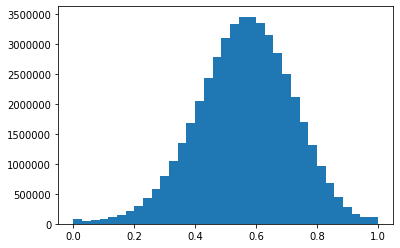

In [11]:
plt.hist(xtest3.flatten(),bins=35)

In [12]:
xtrain = df_train.pres_ano.values[:,:,:,None]
xtest  = df_test.pres_ano.values[:,:,:,None]
xtest2  = df_test2.pres_ano.values[:,:,:,None]
xtest3 = df_test3.pres_ano.values[:,:,:,None]

In [13]:
xtrain.shape,xtest.shape,y_train.shape,y_test.shape

((10839, 13, 90, 1), (1266, 13, 90, 1), (10839, 1), (1266, 1))

In [14]:
batch_size = 100
#num_classes = 10
epochs = 60
data_augmentation = True

In [20]:
import keras
#from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

import os


model = Sequential()
model.add(Conv2D(64*2, (2, 2), padding='same',
                 input_shape=xtrain.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(64*2, (2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64*2, (2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64*2, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.25))

model.add(Conv2D(64*2, (2, 2), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64*2, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('linear'))

# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='mae',optimizer=opt)

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 13, 90, 128)       640       
_________________________________________________________________
activation_17 (Activation)   (None, 13, 90, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 89, 128)       65664     
_________________________________________________________________
activation_18 (Activation)   (None, 12, 89, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 88, 128)       65664     
_________________________________________________________________
activation_19 (Activation)   (None, 11, 88, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 87, 128)      

In [22]:
xtrain1 = xtrain *1 #xtrain.astype('float32')
xtest1 = xtest *1 #xtest.astype('float32')
xtest2 = xtest2*1 #.astype('float32')

xtest3 = xtest3*1 #.astype('float32')

ytrain1 = train_y *1#y_train.values.astype('float32')
ytest1  = test_y *1 #y_test.values.astype('float32')
ytest2  = test_y2*1  #y_test2.values.astype('float32')

In [23]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(xtrain1, ytrain1,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(xtest1, ytest1),
              shuffle=False)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(xtrain1)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0,patience=10)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(xtrain1, ytrain1,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(xtest1, ytest1),callbacks=[es],
                        workers=4)

Using real-time data augmentation.
Epoch 1/60
109/109 [==============================] - 103s 942ms/step - loss: 0.1131 - val_loss: 0.0939
Epoch 2/60
109/109 [==============================] - 102s 938ms/step - loss: 0.0924 - val_loss: 0.0708
Epoch 3/60
109/109 [==============================] - 102s 932ms/step - loss: 0.0877 - val_loss: 0.0678
Epoch 4/60
109/109 [==============================] - 100s 919ms/step - loss: 0.0845 - val_loss: 0.0668
Epoch 5/60
109/109 [==============================] - 99s 912ms/step - loss: 0.0828 - val_loss: 0.0677
Epoch 6/60
109/109 [==============================] - 101s 931ms/step - loss: 0.0834 - val_loss: 0.0685
Epoch 7/60
109/109 [==============================] - 99s 909ms/step - loss: 0.0822 - val_loss: 0.0662
Epoch 8/60
109/109 [==============================] - 100s 914ms/step - loss: 0.0821 - val_loss: 0.0772
Epoch 9/60
109/109 [==============================] - 99s 910ms/step - loss: 0.0826 - val_loss: 0.0657
Epoch 10/60
109/109 [===========

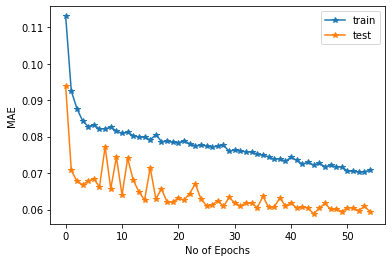

In [24]:
#model.history.keys()

plt.plot(model.history.history['loss'],'-*',label ='train')
plt.plot(model.history.history['val_loss'],'-*',label ='test')
plt.ylabel('MAE')
plt.xlabel('No of Epochs')
plt.legend()
# plt.savefig('RMM2_history.png')

## Correlation

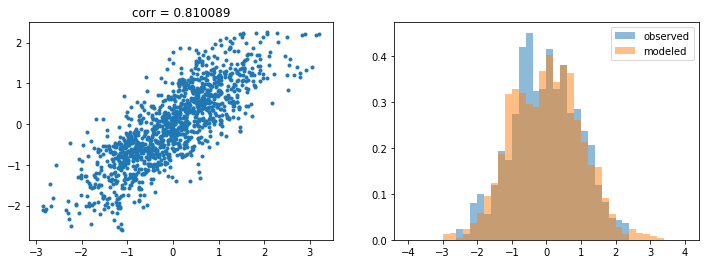

In [27]:
yy_test = model.predict(xtest)
yy_test = sc3.inverse_transform(yy_test)

test_corr = np.corrcoef(yy_test[:,0],y_test.values[:,0])[0,1]
yy_test   = yy_test[:,0]/yy_test[:,0].std()

# print("test shape = ");print(predict2.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_test,y_test.values[:,0],'.')

ax[0].set_title('corr = %f'%test_corr)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_test.values[:,0],bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_test,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

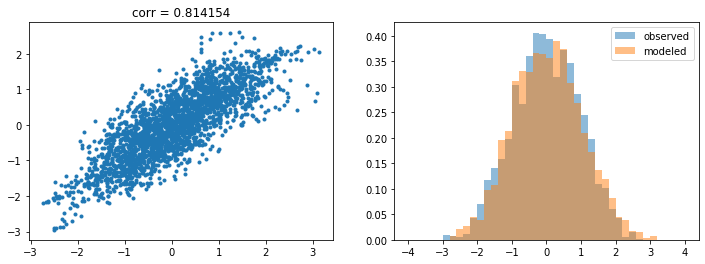

In [29]:
yy_test2 = model.predict(xtest2)
yy_test2 = sc3.inverse_transform(yy_test2)

test_corr2 = np.corrcoef(yy_test2[:,0],y_test2.values[:,0])[0,1]
yy_test2   = yy_test2[:,0]/yy_test2[:,0].std()

# print("test shape = ");print(predict2.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_test2,y_test2.values[:,0],'.')

ax[0].set_title('corr = %f'%test_corr2)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_test2.values[:,0],bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_test2,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

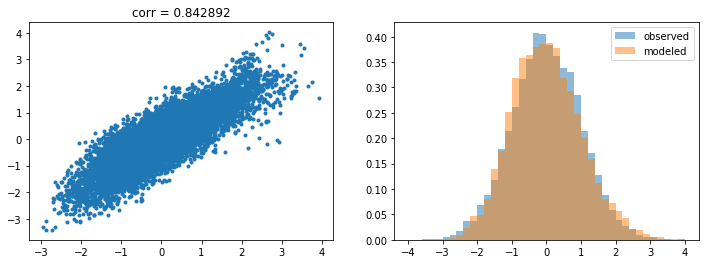

In [30]:
yy_train = model.predict(xtrain)
yy_train = sc3.inverse_transform(yy_train)

train_corr = np.corrcoef(yy_train[:,0],y_train.values[:,0])[0,1]
yy_train   = yy_train[:,0]/yy_train[:,0].std()

# print("train shape = ");print(predict2.shape)

fig,ax = plt.subplots(1,2,figsize = (12,4))

ax[0].plot(yy_train,y_train.values[:,0],'.')

ax[0].set_title('corr = %f'%train_corr)

bins = np.linspace(-4.0,4.0,41)

ax[1].hist(y_train.values[:,0],bins,density=True,alpha=0.5,label='observed')
ax[1].hist(yy_train,bins,density=True,alpha=0.5,label='modeled');
plt.legend()

In [31]:
rmm1 = model.predict(xtest3)
rmm1 = sc3.inverse_transform(rmm1)


In [32]:
rmm1 = pd.DataFrame(rmm1,index=pd.to_datetime(df_test3.time[:].values),columns=['rmm1'])

(array([8.000e+00, 2.700e+01, 8.800e+01, 1.830e+02, 3.270e+02, 5.540e+02,
        8.260e+02, 1.266e+03, 1.695e+03, 2.213e+03, 2.758e+03, 2.982e+03,
        3.201e+03, 3.391e+03, 3.424e+03, 3.361e+03, 3.014e+03, 2.626e+03,
        2.286e+03, 1.786e+03, 1.385e+03, 9.910e+02, 6.930e+02, 5.230e+02,
        3.260e+02, 2.100e+02, 1.160e+02, 7.400e+01, 4.000e+01, 2.500e+01,
        1.100e+01, 8.000e+00, 1.000e+00, 2.000e+00, 1.000e+00]),
 array([-2.298793  , -2.1373322 , -1.9758711 , -1.8144101 , -1.6529491 ,
        -1.4914881 , -1.3300272 , -1.1685662 , -1.0071052 , -0.84564424,
        -0.68418324, -0.52272224, -0.36126125, -0.19980027, -0.03833928,
         0.1231217 ,  0.2845827 ,  0.44604367,  0.60750467,  0.76896566,
         0.93042666,  1.0918876 ,  1.2533486 ,  1.4148096 ,  1.5762706 ,
         1.7377316 ,  1.8991926 ,  2.0606534 ,  2.2221146 ,  2.3835754 ,
         2.5450366 ,  2.7064974 ,  2.8679585 ,  3.0294194 ,  3.1908805 ,
         3.3523414 ], dtype=float32),
 <a list of 35 P

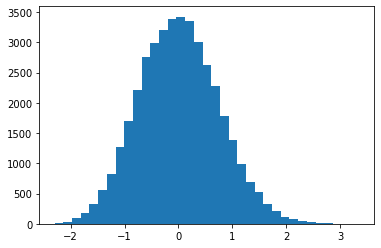

In [33]:
plt.hist(rmm1.rmm1,bins=35)

In [34]:
rmm1.to_csv('test_rmm1.csv')

In [ ]:
plt.plot(rmm2.rmm2)
plt.axhline(3)
plt.axhline(-3)

In [ ]:
# model.save("deep_CNN_rmm2_minmaxscalar_batchsize_100_woymnmx.h5")
# print("Saved model to disk")

In [ ]:
rmm2